In [193]:
import pandas as pd
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.ops import transform
from shapely.affinity import rotate
# from shapely import LineString
# import geopandas as gpd
import numpy as np


from geopy.distance import great_circle
# import matplotlib.pyplot as plt

In [194]:


# Load the CSV file
data = pd.read_csv('../data/kml/college_raw.csv')

# Display the first few rows of the dataframe
data.head()



def parse_coordinates(coordinate_string):
    coordinates = coordinate_string.split()
    coordinates = [tuple(map(float, coord.split(','))) for coord in coordinates]
    return coordinates

def create_polygon(coordinate_string):
    coordinates = parse_coordinates(coordinate_string)
    return Polygon(coordinates)

# Create a new DataFrame
df = data.copy()

# Extract home plate coordinates (first/last point of 'fop' polygon)
df['home_plate'] = df['fop'].apply(lambda x: parse_coordinates(x)[0])
df['foul'] = df['foul'].apply(parse_coordinates)
df['fop'] = df['fop'].apply(parse_coordinates)

# Display the first few rows
# df.head()
len(df)


157

In [195]:

# 4B. Calculate the distance from home plate to the outfield fences
def interpolate_points(start, end, length_ratio):
    start_np = np.array(start)
    end_np = np.array(end)
    return tuple(start_np + (end_np - start_np) * length_ratio)

def calculate_distances(home_plate, outfield_coords, num_points=540):
    def is_same_point(point1, point2, tolerance=1e-6):
        return abs(point1[0] - point2[0]) < tolerance and abs(point1[1] - point2[1]) < tolerance

    home_plate_lat_lon = (home_plate[1], home_plate[0])
    distances = []

    # Calculate total line length
    total_length = 0
    segments = []
    for i in range(len(outfield_coords) - 1):
        start = outfield_coords[i]
        end = outfield_coords[i + 1]
        if not is_same_point(home_plate, start) and not is_same_point(home_plate, end):
            segment_length = great_circle((start[1], start[0]), (end[1], end[0])).feet
            segments.append((start, end, segment_length))
            total_length += segment_length

    # Calculate the distance between equally spaced points
    spacing = total_length / (num_points - 1)

    # Interpolate points and calculate distances
    current_length = 0
    segment_index = 0
    for i in range(num_points):
        while segment_index < len(segments) - 1 and current_length > segments[segment_index][2]:
            current_length -= segments[segment_index][2]
            segment_index += 1

        start, end, segment_length = segments[segment_index]
        length_ratio = current_length / segment_length
        point = interpolate_points(start, end, length_ratio)
        distance = great_circle(home_plate_lat_lon, (point[1], point[0])).feet
        distances.append(distance)

        current_length += spacing

    return distances

In [196]:
df['distances'] = df.apply(lambda row: calculate_distances(row['home_plate'], row['fop']), axis=1)

In [197]:
# df.sample(5)

### OUTPUT CURRENT DATAFRAME FOR FURTHER ANALYSIS

df.to_csv('../TEMP/TOMP_dataframe.csv', index=False)

In [198]:
# Required Libraries
from geopy.distance import geodesic
import numpy as np
import ast

# Swap latitude and longitude
def swap_lat_lon(point):
    return (point[1], point[0], point[2])

# Convert string representation to actual tuple or list
def parse_data(data):
    if isinstance(data, str):
        return ast.literal_eval(data)
    else:
        return data

# Calculate angle between three points
def calculate_angle(p1, p2, p3):
    p1, p2, p3 = map(np.radians, [p1, p2, p3])
    delta_sigma_p1_p2 = np.arccos(np.sin(p1[1]) * np.sin(p2[1]) + np.cos(p1[1]) * np.cos(p2[1]) * np.cos(abs(p1[0] - p2[0])))
    delta_sigma_p2_p3 = np.arccos(np.sin(p2[1]) * np.sin(p3[1]) + np.cos(p2[1]) * np.cos(p3[1]) * np.cos(abs(p2[0] - p3[0])))
    delta_sigma_p1_p3 = np.arccos(np.sin(p1[1]) * np.sin(p3[1]) + np.cos(p1[1]) * np.cos(p3[1]) * np.cos(abs(p1[0] - p3[0])))
    
    # Clip input to avoid numerical instability
    cos_angle = (np.cos(delta_sigma_p1_p3) - np.cos(delta_sigma_p1_p2) * np.cos(delta_sigma_p2_p3)) / (np.sin(delta_sigma_p1_p2) * np.sin(delta_sigma_p2_p3))
    cos_angle = np.clip(cos_angle, -1, 1)
    angle = np.arccos(cos_angle)
    
    return np.degrees(angle)

# Calculate distance between two points
def calculate_distance(p1, p2):
    return geodesic(p1, p2).feet

# Correct home plate
def correct_home_plate(row):
    fop_list = parse_data(row['fop'])
    fop_list = [swap_lat_lon(point) for point in fop_list]
    new_home_plate = parse_data(row['home_plate'])
    for i in range(1, len(fop_list) - 1):
        angle = calculate_angle(fop_list[i-1], fop_list[i], fop_list[i+1])
        distance1 = calculate_distance(fop_list[i], fop_list[i-1])
        distance2 = calculate_distance(fop_list[i], fop_list[i+1])
        if distance1 != 0 and distance2 != 0:
            distance_ratio = max(distance1, distance2) / min(distance1, distance2)
            if 80 <= angle <= 100 and distance1 > 200 and distance2 > 200 and distance_ratio <= 1.2:
                new_home_plate = swap_lat_lon(fop_list[i])
                break
    return str(new_home_plate)

# Copy DataFrame
df_copy = df.copy()

# Correct home plate
df_copy.loc[:, 'home_plate'] = df_copy.apply(correct_home_plate, axis=1)

# Recalculate distances
df_copy.loc[:, 'distances'] = df_copy.apply(lambda row: calculate_distances(parse_data(row['home_plate']), parse_data(row['fop'])), axis=1)

# Update min_distance
df_copy.loc[:, 'min_distance'] = df_copy['distances'].apply(lambda x: min(parse_data(x)))

# Update the original DataFrame with the corrected data
df.update(df_copy)

## Find min_distance (minimum value in the distances list)
df.loc[:, 'min_distance'] = df['distances'].apply(lambda x: min(parse_data(x)))
# Display DataFrame info
df.info()


C:\Users\Justin\AppData\Local\Temp\ipykernel_2780\1415318601.py:25: RuntimeWarning: invalid value encountered in double_scalars
  cos_angle = (np.cos(delta_sigma_p1_p3) - np.cos(delta_sigma_p1_p2) * np.cos(delta_sigma_p2_p3)) / (np.sin(delta_sigma_p1_p2) * np.sin(delta_sigma_p2_p3))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   field         157 non-null    object 
 1   foul          157 non-null    object 
 2   fop           157 non-null    object 
 3   home_plate    157 non-null    object 
 4   distances     157 non-null    object 
 5   min_distance  157 non-null    float64
dtypes: float64(1), object(5)
memory usage: 7.5+ KB


<AxesSubplot:>

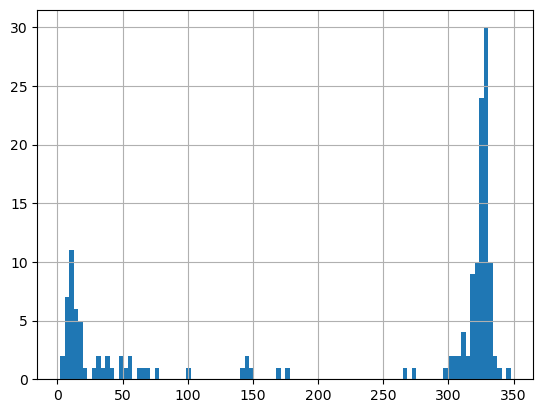

In [199]:
df['min_distance'].hist(bins=100)

In [200]:
import ast

# Convert the strings in 'distances' column to lists
# df['distances'] = df['distances'].apply(ast.literal_eval)

# Extract the first distance from each list in 'distances' column
df['min_distance'] = df['distances'].apply(lambda x: x[0])

# Identify rows with 'min_distance' less than 300 or more than 350
incorrect_rows = df[(df['min_distance'] < 275) | (df['min_distance'] > 400)]

len(incorrect_rows)


55

In [201]:
from geopy.distance import geodesic
import numpy as np

def calculate_angle(p1, p2, p3):
    """
    Calculate the angle at p2 formed by the line segments p1-p2 and p2-p3.
    Points are assumed to be in (longitude, latitude) format.
    """
    # Convert latitude and longitude to radians
    p1 = np.radians(p1)
    p2 = np.radians(p2)
    p3 = np.radians(p3)
    
    # Use the haversine formula to calculate the central angle between each pair of points
    delta_sigma_p1_p2 = np.arccos(np.sin(p1[1]) * np.sin(p2[1]) + np.cos(p1[1]) * np.cos(p2[1]) * np.cos(abs(p1[0] - p2[0])))
    delta_sigma_p2_p3 = np.arccos(np.sin(p2[1]) * np.sin(p3[1]) + np.cos(p2[1]) * np.cos(p3[1]) * np.cos(abs(p2[0] - p3[0])))
    delta_sigma_p1_p3 = np.arccos(np.sin(p1[1]) * np.sin(p3[1]) + np.cos(p1[1]) * np.cos(p3[1]) * np.cos(abs(p1[0] - p3[0])))

    # Use the spherical law of cosines to calculate the angle at p2
    angle = np.arccos((np.cos(delta_sigma_p1_p3) - np.cos(delta_sigma_p1_p2) * np.cos(delta_sigma_p2_p3)) /
                      (np.sin(delta_sigma_p1_p2) * np.sin(delta_sigma_p2_p3)))

    # Convert the angle to degrees
    angle = np.degrees(angle)
    
    return angle

def calculate_distance(p1, p2):
    """
    Calculate the distance between two points.
    Points are assumed to be in (longitude, latitude) format.
    """
    return geodesic(p1, p2).feet






In [202]:
########### HELPER FUNCTIONS ###########
# Swap latitude and longitude
def swap_lat_lon(point):
    return (point[1], point[0], point[2])

def parse_home_plate(home_plate):
    if isinstance(home_plate, str):
        return ast.literal_eval(home_plate)
    else:
        return home_plate
    
def parse_fop(fop):
    if isinstance(fop, str):
        return ast.literal_eval(fop)
    else:
        return fop

df.loc[incorrect_rows.index, 'distances'] = df.loc[incorrect_rows.index].apply(lambda row: calculate_distances(parse_home_plate(row['home_plate']), parse_fop(row['fop'])), axis=1)


# df.loc[incorrect_rows.index, 'distances'] = df.loc[incorrect_rows.index].apply(lambda row: calculate_distances(parse_home_plate(row['home_plate']), ast.literal_eval(row['fop'])), axis=1)
#######################################

df_copy = df.copy()

# Iterate over each incorrect field
for idx, row in incorrect_rows.iterrows():
    # Convert the string representation of the 'fop' list to an actual list
    fop_list = row['fop']
    
    # Swap latitude and longitude for each point in the 'fop' list
    fop_list = [swap_lat_lon(point) for point in fop_list]
    
    # Iterate over each point in the 'fop' list
    for i in range(1, len(fop_list) - 1):  # Exclude the first and last points because they don't have two adjacent points
        # Calculate the angle and distances
        angle = calculate_angle(fop_list[i-1], fop_list[i], fop_list[i+1])
        distance1 = calculate_distance(fop_list[i], fop_list[i-1])
        distance2 = calculate_distance(fop_list[i], fop_list[i+1])
        
        # Check if the distances are within 20% of each other, but only if neither distance is zero
        if distance1 != 0 and distance2 != 0:
            distance_ratio = max(distance1, distance2) / min(distance1, distance2)
            
            # If the angle is between 80 and 100 degrees, both distances are over 200 feet, and the distances are within 20% of each other,
            # set this point as the new 'home_plate' point
            if 80 <= angle <= 100 and distance1 > 200 and distance2 > 200 and distance_ratio <= 1.2:
                df_copy.loc[idx, 'home_plate'] = str(swap_lat_lon(fop_list[i]))
                break



# Recalculate the distances for the corrected fields
df_copy.loc[incorrect_rows.index, 'distances'] = df_copy.loc[incorrect_rows.index].apply(lambda row: calculate_distances(parse_home_plate(row['home_plate']), parse_fop(row['fop'])), axis=1)

# Recalculate the 'min_distance' for the corrected fields
df_copy.loc[incorrect_rows.index, 'min_distance'] = df_copy.loc[incorrect_rows.index]['distances'].apply(lambda x: x[0])

df = df_copy

# Check if there are still fields with incorrect 'home_plate' points
incorrect_rows_after_correction = df[(df['min_distance'] < 300) | (df['min_distance'] > 350)]
# incorrect_rows_after_correction


C:\Users\Justin\AppData\Local\Temp\ipykernel_2780\3971661365.py:20: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos((np.cos(delta_sigma_p1_p3) - np.cos(delta_sigma_p1_p2) * np.cos(delta_sigma_p2_p3)) /
C:\Users\Justin\AppData\Local\Temp\ipykernel_2780\3971661365.py:20: RuntimeWarning: invalid value encountered in double_scalars
  angle = np.arccos((np.cos(delta_sigma_p1_p3) - np.cos(delta_sigma_p1_p2) * np.cos(delta_sigma_p2_p3)) /


In [203]:
len(incorrect_rows_after_correction)
# incorrect_rows_after_correction.head()

58

In [204]:
# New function to handle the correction
def correct_home_plate(row):
    # Convert the string representation of the 'fop' list to an actual list
    fop_list = row['fop']
    
    # Swap latitude and longitude for each point in the 'fop' list
    fop_list = [swap_lat_lon(point) for point in fop_list]
    
    # Initialize a variable to store the new 'home_plate' point
    new_home_plate = row['home_plate']
    
    # Iterate over each point in the 'fop' list
    for i in range(1, len(fop_list) - 1):  # Exclude the first and last points because they don't have two adjacent points
        # Calculate the angle and distances
        angle = calculate_angle(fop_list[i-1], fop_list[i], fop_list[i+1])
        distance1 = calculate_distance(fop_list[i], fop_list[i-1])
        distance2 = calculate_distance(fop_list[i], fop_list[i+1])
        
        # Check if the distances are within 20% of each other, but only if neither distance is zero
        if distance1 != 0 and distance2 != 0:
            distance_ratio = max(distance1, distance2) / min(distance1, distance2)
            
            # If the angle is between 80 and 100 degrees, both distances are over 200 feet, and the distances are within 20% of each other,
            # set this point as the new 'home_plate' point
            if 80 <= angle <= 100 and distance1 > 200 and distance2 > 200 and distance_ratio <= 1.2:
                # Check the points immediately before and after the candidate point
                for j in [i-1, i+1]:
                    if j < 0 or j > len(fop_list) - 1:
                        continue  # Skip if out of bounds

                    # Calculate the angle and distances for the new candidate point
                    angle = calculate_angle(fop_list[j-1], fop_list[j], fop_list[j+1])
                    distance1 = calculate_distance(fop_list[j], fop_list[j-1])
                    distance2 = calculate_distance(fop_list[j], fop_list[j+1])

                    # If the angle is between 80 and 100 degrees, both distances are over 200 feet, 
                    # and the distances are within 20% of each other, set this point as the new 'home_plate' point
                    if 80 <= angle <= 100 and distance1 > 200 and distance2 > 200:
                        new_home_plate = str(swap_lat_lon(fop_list[j]))
                        break
    
    # Recalculate the 'distances' if the 'home_plate' point has been corrected
    if new_home_plate != row['home_plate']:
        new_distances = calculate_distances(parse_home_plate(new_home_plate), parse_fop(row['fop']))
    else:
        new_distances = row['distances']  # If the 'home_plate' point hasn't been corrected, keep the original 'distances'
    
    return new_home_plate, new_distances

# Apply the new function to the incorrect rows
df_copy.loc[incorrect_rows_after_correction.index, ['home_plate', 'distances']] = incorrect_rows_after_correction.apply(correct_home_plate, axis=1, result_type='expand')

# Display the 'home_plate' values for the fields that had incorrect 'home_plate' points
# print(df_copy.loc[incorrect_rows_after_correction.index, 'home_plate'])


C:\Users\Justin\AppData\Local\Temp\ipykernel_2780\3971661365.py:20: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos((np.cos(delta_sigma_p1_p3) - np.cos(delta_sigma_p1_p2) * np.cos(delta_sigma_p2_p3)) /
C:\Users\Justin\AppData\Local\Temp\ipykernel_2780\3971661365.py:20: RuntimeWarning: invalid value encountered in double_scalars
  angle = np.arccos((np.cos(delta_sigma_p1_p3) - np.cos(delta_sigma_p1_p2) * np.cos(delta_sigma_p2_p3)) /


In [205]:
# Display rows where 'distances' is not a list
print(df_copy[df_copy['distances'].apply(lambda x: not isinstance(x, list))])


                                                 field  \
6    Bailey-Brayton Field - Washington State - college   
7          Barcroft Park - George Washington - college   
8        Baylor Ballpark - Baylor University - college   
10         Billiken Sports Center - St Louis - college   
11   Binghamton Baseball Stadium Complex - SNY Bing...   
13                Bolding Stadium - Longwood - college   
15   Buccaneer Ballpark- Charleston Southern - college   
17   Caesar Uyesaka Stadium - UC Santa Barbara - co...   
20        Charles L. Cost Field - Pittsburgh - college   
22   Cicerone Field at Anteater Ballpark- UC Irvine...   
24     Cleveland S. Harley Baseball Park - USC Upstate   
28                      Conaty Park - Bryant - college   
30   Coy O. Williard Baseball Stadium- High Point -...   
32                        Dedeaux Field- USC - college   
33      Dobbin's Baseball Complex - UC Davis - college   
35         Earl Lorden Field - UMass Amherst - college   
39        Evan

C:\Users\Justin\AppData\Local\Temp\ipykernel_2780\853959746.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['min_distance'] = df_copy['distances'].apply(lambda x: min(x))


<AxesSubplot:>

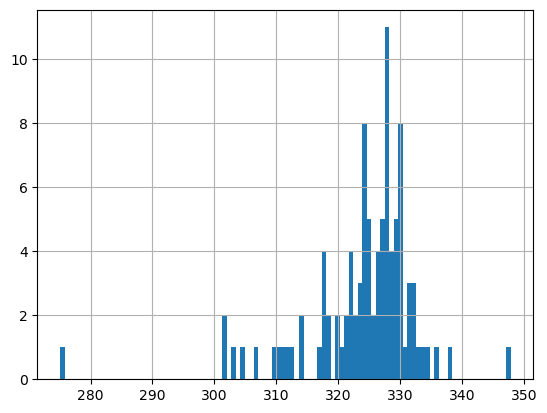

In [206]:
## get the new min_distance from the recalculated list of distances
# df_copy['min_new'] = df_copy['distances'].apply(lambda x: min(x))
# drop the old min_distance column
## Drop rows with missing values
df_copy = df_copy.dropna()


## find the smallest distance for each row's list of distances
df_copy['min_distance'] = df_copy['distances'].apply(lambda x: min(x))

df_copy.dtypes
# get the new min_distance from the recalculated list of distances
# df_copy['min_new'] = df_copy['distances'].apply(lambda x: min(x))

# df_copy.info()
# df_copy.head()
df_copy['min_distance'].hist(bins=100)



In [207]:
### save df_copy to csv
df_copy.to_csv('../TEMP/Corrected Fields_df_copy.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 155
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   field         99 non-null     object 
 1   foul          99 non-null     object 
 2   fop           99 non-null     object 
 3   home_plate    99 non-null     object 
 4   distances     99 non-null     object 
 5   min_distance  99 non-null     float64
dtypes: float64(1), object(5)
memory usage: 5.4+ KB


<AxesSubplot:>

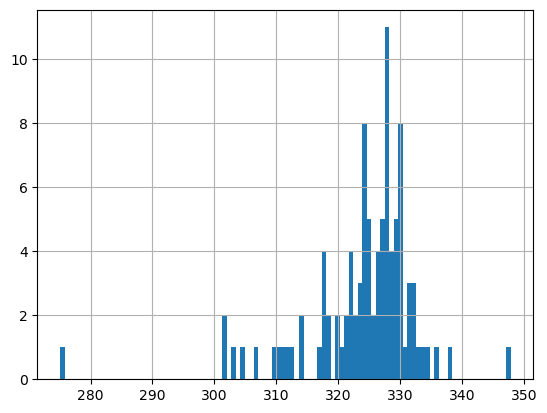

In [208]:
df_copy.info()

df_copy['min_distance'].hist(bins=100)

In [209]:
## Reload original data from TOMP file
# TEMP\TOMP_dataframe.csv
reload_df = pd.read_csv('../TEMP/TOMP_dataframe.csv')


reload_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   field       157 non-null    object
 1   foul        157 non-null    object
 2   fop         157 non-null    object
 3   home_plate  157 non-null    object
 4   distances   157 non-null    object
dtypes: object(5)
memory usage: 6.3+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   field         157 non-null    object 
 1   foul          157 non-null    object 
 2   fop           157 non-null    object 
 3   home_plate    157 non-null    object 
 4   distances     157 non-null    object 
 5   min_distance  157 non-null    float64
dtypes: float64(1), object(5)
memory usage: 7.5+ KB


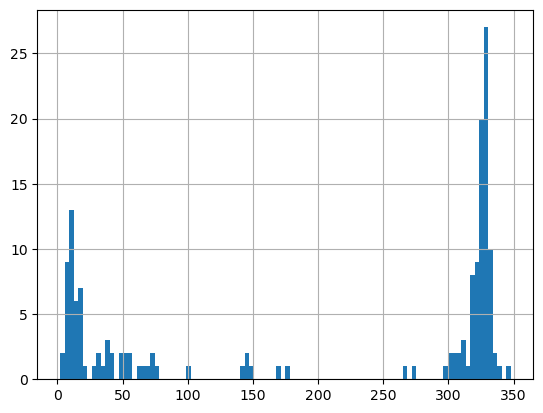

In [210]:
import ast
# ## find the smallest distance for each row's list of distances
# # convert string to list
reload_df['distances'] = reload_df['distances'].apply(lambda x: ast.literal_eval(x))

# ## find the smallest distance for each row's list of distances
reload_df['min_distance'] = reload_df['distances'].apply(lambda x: min(x))

reload_df['min_distance'].hist(bins=100)
reload_df.info()

# reload_df.head()

In [211]:
## Drop all rows that have min distances less than 275

filt_df = reload_df[reload_df['min_distance'] > 275]
len(filt_df)

90

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   field         189 non-null    object 
 1   foul          189 non-null    object 
 2   fop           189 non-null    object 
 3   home_plate    189 non-null    object 
 4   distances     189 non-null    object 
 5   min_distance  189 non-null    float64
 6   max_distance  189 non-null    float64
dtypes: float64(2), object(5)
memory usage: 10.5+ KB


<AxesSubplot:>

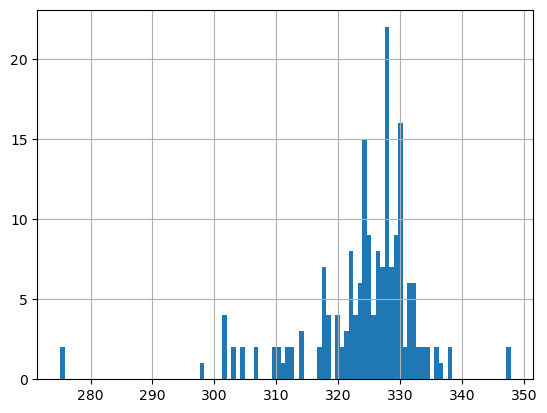

In [212]:
## add the two dataframes together
df = pd.concat([filt_df, df_copy], axis=0, ignore_index=True)
# calculate max_distance from distances list
df['max_distance'] = df['distances'].apply(lambda x: max(x))


df.info()

df['min_distance'].describe()
df['min_distance'].hist(bins=100)

189


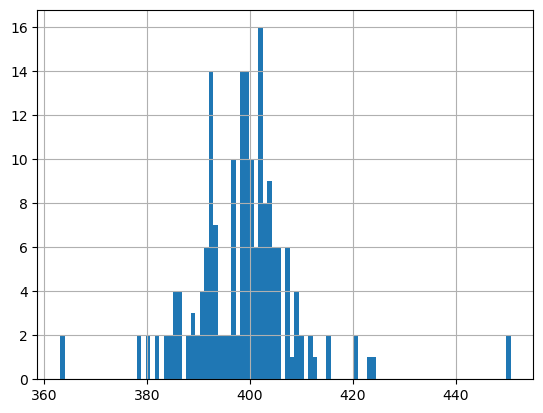

In [213]:
## min distance histogram
df['max_distance'].hist(bins=100)
print(len(df))

In [214]:
# drop duplicate rows
# df = df.drop_duplicates()
df.describe()

# len(df)

df['field'].value_counts()

## filter the rows that occur more than 1 time
df = df[df['field'].isin(df['field'].value_counts()[df['field'].value_counts() > 1].index)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176 entries, 0 to 188
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   field         176 non-null    object 
 1   foul          176 non-null    object 
 2   fop           176 non-null    object 
 3   home_plate    176 non-null    object 
 4   distances     176 non-null    object 
 5   min_distance  176 non-null    float64
 6   max_distance  176 non-null    float64
dtypes: float64(2), object(5)
memory usage: 11.0+ KB


In [215]:
### OUTPUT DF TO CSV
df.to_csv('../TEMP/corrected_fields_v1.csv', index=False)

In [216]:
############## NEW CHATGPT disscussion ##############
### Now that fields are clean do some analysis

import pandas as pd

fields_df = pd.read_csv('../TEMP/corrected_fields_v1.csv')

In [217]:
import ast
from shapely.geometry import Polygon, Point

# Convert string representations of lists and tuples into actual lists and tuples
fields_df['fop'] = fields_df['fop'].apply(ast.literal_eval)
fields_df['home_plate'] = fields_df['home_plate'].apply(ast.literal_eval)

# Convert lists of vertices and home plate coordinates into Shapely Polygon and Point objects
fields_df['fop'] = fields_df['fop'].apply(lambda x: Polygon(x))
fields_df['home_plate'] = fields_df['home_plate'].apply(lambda x: Point(x[0], x[1]))

# Display the DataFrame after the conversion
# fields_df.head()


In [218]:
from shapely.geometry import LineString
import numpy as np
from shapely.geometry import LineString
import numpy as np

def find_center_field_point(field_polygon, home_plate):
    # Create a LineString from the field polygon
    field_boundary = LineString(list(field_polygon.exterior.coords))

    # Find the two points on the boundary that are closest to home plate
    # These points form the vertex with home plate
    point1 = field_boundary.interpolate(field_boundary.project(home_plate))
    point2 = field_boundary.interpolate(-field_boundary.project(home_plate))

    # Calculate the angles of these points with respect to the x-axis
    angle1 = np.arctan2(point1.y - home_plate.y, point1.x - home_plate.x)
    angle2 = np.arctan2(point2.y - home_plate.y, point2.x - home_plate.x)

    # Average the two angles to find the direction of center field
    center_angle = (angle1 + angle2) / 2

    # Create a line from home plate in the direction of center field
    center_line = LineString([home_plate, Point(home_plate.x + np.cos(center_angle), home_plate.y + np.sin(center_angle))])

    # Find the point where this line intersects the field boundary
    ## if there are more than 1 intersection, just return the first one
    center_field_point = field_boundary.intersection(center_line)
    

    return center_field_point

# Apply the function to each row in the DataFrame
fields_df['center_field_point'] = fields_df.apply(lambda row: find_center_field_point(row['fop'], row['home_plate']), axis=1)

# Display the DataFrame
fields_df.head()



,field,foul,fop,home_plate,distances,min_distance,max_distance,center_field_point
0,Adrian College,"[(-84.0697145, 41.901861, 0.0), (-84.0703958, ...","POLYGON Z ((-84.0697145 41.901861 0, -84.06872...",POINT (-84.0697145 41.901861),"[321.7670213730928, 322.09019219891024, 322.41...",321.764389,393.044251,POINT Z (-84.0697145 41.901861 0)
1,Alabama - Sewell–Thomas Stadium,"[(-87.5387466, 33.2052609, 0.0), (-87.5378045,...","POLYGON Z ((-87.5387466 33.2052609 0, -87.5392...",POINT (-87.5387466 33.2052609),"[320.1478244398133, 320.34019109978664, 320.53...",319.926075,393.357127,POINT Z (-87.5387466 33.2052609 0)
2,Albion College - college,"[(-84.7373745, 42.241567, 0.0), (-84.7373704, ...","POLYGON Z ((-84.7373745 42.241567 0, -84.73614...",POINT (-84.7373745 42.241567),"[330.72958457917105, 330.9045318390348, 331.08...",330.729585,411.985238,POINT Z (-84.7373745 42.241567 0)
3,Arizona - Hi Corbett Field - college,"[(-110.9194283, 32.2131913, 0.0), (-110.919416...","POLYGON Z ((-110.9194283 32.2131913 0, -110.92...",POINT (-110.9194283 32.2131913),"[347.9205939826052, 347.9200599896452, 347.923...",347.920060,407.181605,POINT Z (-110.9194283 32.2131913 0)
4,Arkansas - Baum-Walker Stadium - college,"[(-94.1827419, 36.0502882, 0.0), (-94.1816529,...","POLYGON Z ((-94.1827419 36.0502882 0, -94.1827...",POINT (-94.1827419 36.0502882),"[321.2423961960251, 321.3015057504639, 321.364...",321.242396,399.336627,POINT Z (-94.1827419 36.0502882 0)


In [219]:
# Display the DataFrame
fields_df.to_csv('../TEMP/TOMP_fields.csv', index=False)




In [220]:
df = pd.read_csv('../TEMP/TOMP_fields.csv')

In [221]:
from shapely import wkt

# Convert 'fop' and 'home_plate' from WKT to shapely objects
df['fop'] = df['fop'].apply(wkt.loads)
df['home_plate'] = df['home_plate'].apply(wkt.loads)

# Display the updated DataFrame
# df.head()


In [222]:
import numpy as np
from shapely.geometry import LineString

def calculate_angle(point1, point2, ref_point):
    """
    Function to calculate the angle between the line defined by point1 and point2, and the line defined by ref_point and point2.
    The angle will be between -180 and 180, with negative values to the left of the reference line and positive values to the right.
    All points are assumed to have x and y coordinates.
    """
    # Calculate the vectors
    vector1 = [point1.x - point2.x, point1.y - point2.y]
    vector2 = [ref_point.x - point2.x, ref_point.y - point2.y]
    
    # Calculate the dot product and the magnitudes of the vectors
    dot_product = vector1[0] * vector2[0] + vector1[1] * vector2[1]
    magnitude1 = np.sqrt(vector1[0]**2 + vector1[1]**2)
    magnitude2 = np.sqrt(vector2[0]**2 + vector2[1]**2)
    
    # Calculate the cosine of the angle
    cos_angle = dot_product / (magnitude1 * magnitude2)
    
    # Calculate the angle in degrees
    angle = np.degrees(np.arccos(cos_angle))
    
    # Determine the sign of the angle
    cross_product = vector1[0] * vector2[1] - vector1[1] * vector2[0]
    if cross_product < 0:
        angle = -angle
    
    return angle

from shapely.geometry import Point

def segment_field(fop, home_plate):
    """
    Function to segment a field of play into different sections based on the angle from the home plate to the boundary points.
    The sections are 'down the line', 'porch', 'power alleys', and 'center field'.
    """
    try:
        # Create a LineString from the boundary of the field of play
        boundary = LineString(fop.exterior.coords)

        # Create a reference line from the home plate to the center field point
        center_field_point = boundary.interpolate(boundary.project(home_plate))

        # Calculate the angle from the home plate to each point on the boundary
        angles = [calculate_angle(Point(point), home_plate, center_field_point) for point in boundary.coords]

        # Segment the field into different sections based on the angles
        segments = {
            'down_the_line': LineString([point for point, angle in zip(boundary.coords, angles) if -5 <= angle <= 5]),
            'porch': LineString([point for point, angle in zip(boundary.coords, angles) if (-20 <= angle < -5) or (5 < angle <= 20)]),
            'power_alleys': LineString([point for point, angle in zip(boundary.coords, angles) if (-30 <= angle < -20) or (20 < angle <= 30)]),
            'center_field': LineString([point for point, angle in zip(boundary.coords, angles) if -30 > angle or angle > 30])
        }
    except Exception as e:
        print(f"An error occurred: {e}")
        print(f"home_plate type: {type(home_plate)}, value: {home_plate}")
        print(f"center_field_point type: {type(center_field_point)}, value: {center_field_point}")
        segments = None
    
    return segments

# Segment each field into different sections
df['segments'] = df.apply(lambda row: segment_field(row['fop'], row['home_plate']), axis=1)

# Display the updated DataFrame
df.head()


# Segment each field into different sections
df['segments'] = df.apply(lambda row: segment_field(row['fop'], row['home_plate']), axis=1)

# Display the updated DataFrame
# df.head()


C:\Users\Justin\AppData\Local\Temp\ipykernel_2780\3082459904.py:20: RuntimeWarning: invalid value encountered in double_scalars
  cos_angle = dot_product / (magnitude1 * magnitude2)


In [223]:
from shapely.geometry import MultiLineString
from shapely.geometry import LineString, MultiPoint
from shapely.ops import unary_union
from shapely.geometry import Point, Polygon

def create_ray(origin, angle, length=1e3):
    """Create a ray (line) from the origin at a certain angle."""
    # Convert the angle to radians
    angle_rad = np.radians(angle)
    
    # Calculate the end point
    end_point = Point(origin.x + length * np.cos(angle_rad), origin.y + length * np.sin(angle_rad))
    
    return LineString([origin, end_point])

def intersect_ray_with_polygon(ray, polygon):
    """Intersect a ray with a polygon and return the intersection point."""
    intersection = ray.intersection(polygon)
    
    # If the intersection is a LineString, return one of its end points
    if isinstance(intersection, LineString):
        intersection = Point(intersection.coords[-1])
    
    # If the intersection is a MultiPoint, return the point closest to the home plate
    elif isinstance(intersection, MultiPoint):
        intersection = min(intersection, key=lambda point: home_plate.distance(point))
    
    # If the intersection is a MultiLineString, return the end point of the line closest to the home plate
    elif isinstance(intersection, MultiLineString):
        intersection = Point(min(intersection, key=lambda line: home_plate.distance(line)).coords[-1])

    # If the intersection is not a Point, return None
    elif not isinstance(intersection, Point):
        return None

    return intersection

def segment_field_into_polygons(fop, home_plate):
    """Segment a field of play into different sections based on the angle from the home plate."""
    # Define the mid-angles for each segment
    mid_angles = [-45, -27.5, -12.5, 0, 12.5, 27.5, 45]

    # Define the names of the segments
    segment_names = ['down_the_line_left', 'porch_left', 'power_alleys_left', 'center_field', 'power_alleys_right', 'porch_right', 'down_the_line_right']

    # Create rays from the home plate at the mid-angles
    rays = [create_ray(home_plate, angle) for angle in mid_angles]

    # Intersect the rays with the field of play to get the boundary points of each segment
    intersection_points = [intersect_ray_with_polygon(ray, fop) for ray in rays]

    # Filter out None intersection points
    intersection_points = [point for point in intersection_points if point is not None]

    # Sort the boundary points by angle
    sorted_points = sorted(intersection_points, key=lambda point: calculate_angle(point, home_plate, Point(0, 0)))

    # Create polygons for each segment
    segments = {}
    for i in range(len(sorted_points)-1):
        # Create a LineString from the field's exterior
        exterior_line = LineString(list(fop.exterior.coords))

        # Intersect the exterior line with the two rays
        point1 = exterior_line.intersection(rays[i])
        point2 = exterior_line.intersection(rays[i+1])

        # If the intersection is not a Point, convert it to a point
        if isinstance(point1, MultiPoint):
            point1 = Point(min((p for p in point1), key=lambda point: home_plate.distance(point)).coords[-1])
        elif not isinstance(point1, Point):
            point1 = Point(point1.x, point1.y)

        if isinstance(point2, MultiPoint):
            point2 = Point(min((p for p in point2), key=lambda point: home_plate.distance(point)).coords[-1])
        elif not isinstance(point2, Point):
            point2 = Point(point2.x, point2.y)

        # Create a polygon from the home plate, the two intersection points, and the two points on the field's exterior
        segments[segment_names[i]] = Polygon([Point(home_plate.x, home_plate.y), Point(sorted_points[i].x, sorted_points[i].y), Point(sorted_points[i+1].x, sorted_points[i+1].y), Point(point2.x, point2.y), Point(point1.x, point1.y)])

    if len(sorted_points) > 1:
        # Handle the last segment separately
        i = len(sorted_points) - 1
        point1 = exterior_line.intersection(rays[i])
        point2 = exterior_line.intersection(rays[0])  # Wrap around to the start

        if isinstance(point1, MultiPoint):
            point1 = Point(min((p for p in point1), key=lambda point: home_plate.distance(point)).coords[-1])
        elif not isinstance(point1, Point):
            point1 = Point(point1.x, point1.y)

        if isinstance(point2, MultiPoint):
            point2 = Point(min((p for p in point2), key=lambda point: home_plate.distance(point)).coords[-1])
        elif not isinstance(point2, Point):
            point2 = Point(point2.x, point2.y)
        
        # Create a polygon from the home plate, the two intersection points, and the two points on the field's exterior
        segments[segment_names[i]] = Polygon([Point(home_plate.x, home_plate.y), Point(sorted_points[i].x, sorted_points[i].y), Point(sorted_points[0].x, sorted_points[0].y), Point(point2.x, point2.y), Point(point1.x, point1.y)])
    
    return segments

# Segment each field into polygons for each section
df_segments = df.apply(lambda row: segment_field_into_polygons(row['fop'], row['home_plate']), axis=1)

# Convert the segments into separate DataFrame columns
df_segments = pd.json_normalize(df_segments)

# Merge the segments DataFrame with the original DataFrame
df = pd.concat([df, df_segments], axis=1)

# Display the updated DataFrame
df.head()



C:\Users\Justin\AppData\Local\Temp\ipykernel_2780\3082459904.py:20: RuntimeWarning: invalid value encountered in double_scalars
  cos_angle = dot_product / (magnitude1 * magnitude2)


,field,foul,fop,home_plate,distances,min_distance,max_distance,center_field_point,segments,down_the_line_left,porch_left,power_alleys_left,center_field,power_alleys_right,porch_right,down_the_line_right
0,Adrian College,"[(-84.0697145, 41.901861, 0.0), (-84.0703958, ...","POLYGON Z ((-84.0697145 41.901861 0, -84.06872...",POINT (-84.0697145 41.901861),"[321.7670213730928, 322.09019219891024, 322.41...",321.764389,393.044251,POINT Z (-84.0697145 41.901861 0),"{'down_the_line': GEOMETRYCOLLECTION EMPTY, 'p...","POLYGON ((-84.0697145 41.901861, -84.0697145 4...","POLYGON ((-84.0697145 41.901861, -84.0697145 4...","POLYGON ((-84.0697145 41.901861, -84.0697145 4...","POLYGON ((-84.0697145 41.901861, -84.0697145 4...","POLYGON ((-84.0697145 41.901861, -84.0697145 4...","POLYGON ((-84.0697145 41.901861, -84.068905110...","POLYGON ((-84.0697145 41.901861, -84.068734721..."
1,Alabama - Sewell–Thomas Stadium,"[(-87.5387466, 33.2052609, 0.0), (-87.5378045,...","POLYGON Z ((-87.5387466 33.2052609 0, -87.5392...",POINT (-87.5387466 33.2052609),"[320.1478244398133, 320.34019109978664, 320.53...",319.926075,393.357127,POINT Z (-87.5387466 33.2052609 0),"{'down_the_line': GEOMETRYCOLLECTION EMPTY, 'p...","POLYGON ((-87.5387466 33.2052609, -87.53784398...","POLYGON ((-87.5387466 33.2052609, -87.53799955...","POLYGON ((-87.5387466 33.2052609, -87.5387466 ...","POLYGON ((-87.5387466 33.2052609, -87.5387466 ...","POLYGON ((-87.5387466 33.2052609, -87.5387466 ...","POLYGON ((-87.5387466 33.2052609, -87.5387466 ...","POLYGON ((-87.5387466 33.2052609, -87.5387466 ..."
2,Albion College - college,"[(-84.7373745, 42.241567, 0.0), (-84.7373704, ...","POLYGON Z ((-84.7373745 42.241567 0, -84.73614...",POINT (-84.7373745 42.241567),"[330.72958457917105, 330.9045318390348, 331.08...",330.729585,411.985238,POINT Z (-84.7373745 42.241567 0),"{'down_the_line': GEOMETRYCOLLECTION EMPTY, 'p...","POLYGON ((-84.7373745 42.241567, -84.7373745 4...","POLYGON ((-84.7373745 42.241567, -84.7373745 4...","POLYGON ((-84.7373745 42.241567, -84.7373745 4...","POLYGON ((-84.7373745 42.241567, -84.7373745 4...","POLYGON ((-84.7373745 42.241567, -84.736485059...","POLYGON ((-84.7373745 42.241567, -84.736141216...","POLYGON ((-84.7373745 42.241567, -84.7361259 4..."
3,Arizona - Hi Corbett Field - college,"[(-110.9194283, 32.2131913, 0.0), (-110.919416...","POLYGON Z ((-110.9194283 32.2131913 0, -110.92...",POINT (-110.9194283 32.2131913),"[347.9205939826052, 347.9200599896452, 347.923...",347.920060,407.181605,POINT Z (-110.9194283 32.2131913 0),"{'down_the_line': GEOMETRYCOLLECTION EMPTY, 'p...","POLYGON ((-110.9194283 32.2131913, -110.919428...","POLYGON ((-110.9194283 32.2131913, -110.919428...","POLYGON ((-110.9194283 32.2131913, -110.919428...","POLYGON ((-110.9194283 32.2131913, -110.919428...","POLYGON ((-110.9194283 32.2131913, -110.919428...","POLYGON ((-110.9194283 32.2131913, -110.919428...","POLYGON ((-110.9194283 32.2131913, -110.919428..."
4,Arkansas - Baum-Walker Stadium - college,"[(-94.1827419, 36.0502882, 0.0), (-94.1816529,...","POLYGON Z ((-94.1827419 36.0502882 0, -94.1827...",POINT (-94.1827419 36.0502882),"[321.2423961960251, 321.3015057504639, 321.364...",321.242396,399.336627,POINT Z (-94.1827419 36.0502882 0),"{'down_the_line': GEOMETRYCOLLECTION EMPTY, 'p...","POLYGON ((-94.1827419 36.0502882, -94.18161423...","POLYGON ((-94.1827419 36.0502882, -94.18165061...","POLYGON ((-94.1827419 36.0502882, -94.18189282...","POLYGON ((-94.1827419 36.0502882, -94.1827419 ...","POLYGON ((-94.1827419 36.0502882, -94.1827419 ...","POLYGON ((-94.1827419 36.0502882, -94.1827419 ...","POLYGON ((-94.1827419 36.0502882, -94.1827419 ..."


In [224]:
df.info()

## OUTPUT csv
df.to_csv('../TEMP/TOMP_dataframe.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   field                176 non-null    object 
 1   foul                 176 non-null    object 
 2   fop                  176 non-null    object 
 3   home_plate           176 non-null    object 
 4   distances            176 non-null    object 
 5   min_distance         176 non-null    float64
 6   max_distance         176 non-null    float64
 7   center_field_point   176 non-null    object 
 8   segments             176 non-null    object 
 9   down_the_line_left   176 non-null    object 
 10  porch_left           176 non-null    object 
 11  power_alleys_left    176 non-null    object 
 12  center_field         176 non-null    object 
 13  power_alleys_right   176 non-null    object 
 14  porch_right          176 non-null    object 
 15  down_the_line_right  176 non-null    obj

In [225]:
# Drop the 'segments' column as per the user's request
df.drop(columns=['segments'], inplace=True)

# Display the updated DataFrame
df.head()


,field,foul,fop,home_plate,distances,min_distance,max_distance,center_field_point,down_the_line_left,porch_left,power_alleys_left,center_field,power_alleys_right,porch_right,down_the_line_right
0,Adrian College,"[(-84.0697145, 41.901861, 0.0), (-84.0703958, ...","POLYGON Z ((-84.0697145 41.901861 0, -84.06872...",POINT (-84.0697145 41.901861),"[321.7670213730928, 322.09019219891024, 322.41...",321.764389,393.044251,POINT Z (-84.0697145 41.901861 0),"POLYGON ((-84.0697145 41.901861, -84.0697145 4...","POLYGON ((-84.0697145 41.901861, -84.0697145 4...","POLYGON ((-84.0697145 41.901861, -84.0697145 4...","POLYGON ((-84.0697145 41.901861, -84.0697145 4...","POLYGON ((-84.0697145 41.901861, -84.0697145 4...","POLYGON ((-84.0697145 41.901861, -84.068905110...","POLYGON ((-84.0697145 41.901861, -84.068734721..."
1,Alabama - Sewell–Thomas Stadium,"[(-87.5387466, 33.2052609, 0.0), (-87.5378045,...","POLYGON Z ((-87.5387466 33.2052609 0, -87.5392...",POINT (-87.5387466 33.2052609),"[320.1478244398133, 320.34019109978664, 320.53...",319.926075,393.357127,POINT Z (-87.5387466 33.2052609 0),"POLYGON ((-87.5387466 33.2052609, -87.53784398...","POLYGON ((-87.5387466 33.2052609, -87.53799955...","POLYGON ((-87.5387466 33.2052609, -87.5387466 ...","POLYGON ((-87.5387466 33.2052609, -87.5387466 ...","POLYGON ((-87.5387466 33.2052609, -87.5387466 ...","POLYGON ((-87.5387466 33.2052609, -87.5387466 ...","POLYGON ((-87.5387466 33.2052609, -87.5387466 ..."
2,Albion College - college,"[(-84.7373745, 42.241567, 0.0), (-84.7373704, ...","POLYGON Z ((-84.7373745 42.241567 0, -84.73614...",POINT (-84.7373745 42.241567),"[330.72958457917105, 330.9045318390348, 331.08...",330.729585,411.985238,POINT Z (-84.7373745 42.241567 0),"POLYGON ((-84.7373745 42.241567, -84.7373745 4...","POLYGON ((-84.7373745 42.241567, -84.7373745 4...","POLYGON ((-84.7373745 42.241567, -84.7373745 4...","POLYGON ((-84.7373745 42.241567, -84.7373745 4...","POLYGON ((-84.7373745 42.241567, -84.736485059...","POLYGON ((-84.7373745 42.241567, -84.736141216...","POLYGON ((-84.7373745 42.241567, -84.7361259 4..."
3,Arizona - Hi Corbett Field - college,"[(-110.9194283, 32.2131913, 0.0), (-110.919416...","POLYGON Z ((-110.9194283 32.2131913 0, -110.92...",POINT (-110.9194283 32.2131913),"[347.9205939826052, 347.9200599896452, 347.923...",347.920060,407.181605,POINT Z (-110.9194283 32.2131913 0),"POLYGON ((-110.9194283 32.2131913, -110.919428...","POLYGON ((-110.9194283 32.2131913, -110.919428...","POLYGON ((-110.9194283 32.2131913, -110.919428...","POLYGON ((-110.9194283 32.2131913, -110.919428...","POLYGON ((-110.9194283 32.2131913, -110.919428...","POLYGON ((-110.9194283 32.2131913, -110.919428...","POLYGON ((-110.9194283 32.2131913, -110.919428..."
4,Arkansas - Baum-Walker Stadium - college,"[(-94.1827419, 36.0502882, 0.0), (-94.1816529,...","POLYGON Z ((-94.1827419 36.0502882 0, -94.1827...",POINT (-94.1827419 36.0502882),"[321.2423961960251, 321.3015057504639, 321.364...",321.242396,399.336627,POINT Z (-94.1827419 36.0502882 0),"POLYGON ((-94.1827419 36.0502882, -94.18161423...","POLYGON ((-94.1827419 36.0502882, -94.18165061...","POLYGON ((-94.1827419 36.0502882, -94.18189282...","POLYGON ((-94.1827419 36.0502882, -94.1827419 ...","POLYGON ((-94.1827419 36.0502882, -94.1827419 ...","POLYGON ((-94.1827419 36.0502882, -94.1827419 ...","POLYGON ((-94.1827419 36.0502882, -94.1827419 ..."


In [226]:
import pandas as pd
import numpy as np
import shapely

print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Shapely version:', shapely.__version__)


Pandas version: 1.3.2
Numpy version: 1.21.2
Shapely version: 1.7.1


In [227]:
df['home_plate'].dtype

df['home_plate'] = df['home_plate'].astype(str)

In [228]:
import folium

# Define the colors for each segment
colors = {
    'down_the_line_left': 'blue',
    'down_the_line_right': 'blue',
    'porch_left': 'green',
    'porch_right': 'green',
    'power_alleys_left': 'red',
    'power_alleys_right': 'red',
    'center_field': 'yellow'
}



# Choose the first field
field = df.iloc[12]

# Parse the home plate data
home_plate = wkt.loads(field['home_plate'])

segment_cols = ['down_the_line_left', 'down_the_line_right', 'porch_left', 'porch_right',
                'power_alleys_left', 'power_alleys_right', 'center_field']


# Create a map centered at the home plate
m = folium.Map(location=[home_plate.y, home_plate.x], zoom_start=15)

# For each segment
for col in segment_cols:
    # Parse the polygon data
    polygon = field[col]

    # Add the polygon to the map
    folium.vector_layers.Polygon(locations=[(point[1], point[0]) for point in polygon.exterior.coords], 
                                 fill=True, 
                                 color=colors[col], 
                                 fill_color=colors[col], 
                                 fill_opacity=0.5).add_to(m)

# Save the map to an HTML file
m




In [229]:
### Calculate the area of each of the field segments in square feet
import geopandas as gpd
from shapely.geometry import Polygon

# Create a GeoDataFrame from the DataFrame
gdf = gpd.GeoDataFrame(df, geometry=segment_cols)

# Convert the coordinate system to UTM (e.g., zone 19N for certain regions of North America)
gdf = gdf.to_crs(epsg=32619)  # EPSG code 32619 represents UTM zone 19N

# Calculate the area in square meters
df_areas_meters = gdf.area



ModuleNotFoundError: No module named 'geopandas'